In [1]:
from sam2.build_sam import build_sam2
from sam2.sam2_video_predictor import SAM2VideoPredictor
import numpy as np
import torch
import cv2
import json
import matplotlib.pyplot as plt
from pathlib import Path

from typing import Any

In [2]:
training_data_path = Path("/home/dherrera/data/elephants/new_elephant_data/")
camera_name = "Kamera 01"
video_file = (
    training_data_path
    / camera_name
    / "20240907PM/ELP-Kamera-01-20240907-185521-1725728121288-7.mp4"
)
json_path = video_file.with_name(
    video_file.with_suffix("").name + "_points"
).with_suffix(".json")

print(json_path)
with json_path.open("r") as f:
    data = json.load(f)

# Sort data
data = sorted(data, key=lambda x: x["frame"])

video = cv2.VideoCapture(video_file)
video_frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Video frames: {video_frame_count}, labelled: {len(data)}")

obj_count = np.max([len(x["records"]) for x in data])
print(f"Objects: {obj_count}")

distance_to_next_label = [
    data[i + 1]["frame"] - data[i]["frame"] for i in range(len(data) - 1)
]
distance_to_next_label.append(video_frame_count - data[-1]["frame"])
print("distance_to_next_label: ", distance_to_next_label)

/home/dherrera/data/elephants/new_elephant_data/Kamera 01/20240907PM/ELP-Kamera-01-20240907-185521-1725728121288-7_points.json
Video frames: 187175, labelled: 11
Objects: 1
distance_to_next_label:  [19343, 33851, 3982, 5121, 785, 68, 142, 6400, 13939, 20765, 82779]


In [3]:
i = 0
data_i = data[i]
frame_index = data_i["frame"]
record_count = len(data_i["records"])
positive_points = np.stack(
    [
        np.array(x["ppoints"], dtype=np.float32).reshape((-1, 2))
        for x in data_i["records"]
    ]
)
negative_points = np.stack(
    [
        np.array(x["npoints"], dtype=np.float32).reshape((-1, 2))
        for x in data_i["records"]
    ]
)
display(positive_points.shape, positive_points)
display(negative_points.shape, negative_points)

(1, 1, 2)

array([[[998.3421 , 216.57755]]], dtype=float32)

(1, 0, 2)

array([], shape=(1, 0, 2), dtype=float32)

In [4]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2)
    )

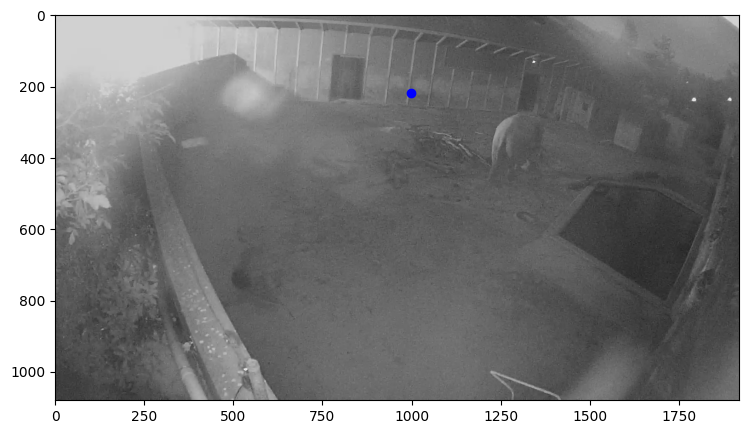

In [5]:
video.set(cv2.CAP_PROP_POS_FRAMES, 70072)  # data_i["frame"])
valid_frame, frame = video.read()
assert valid_frame
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(frame)
for points in positive_points:
    for p in points:
        ax.plot(p[0], p[1], "o", color="blue")
for points in negative_points:
    for p in points:
        ax.plot(p[0], p[1], "o", color="red")

In [6]:
from sam2.build_sam import build_sam2, build_sam2_video_predictor
from sam2.sam2_video_predictor import SAM2VideoPredictor

assert torch.cuda.is_available()
# use bfloat16 for the entire notebook
torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
# turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

sam2_checkpoint = "../../models/sam2/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor: SAM2VideoPredictor = build_sam2_video_predictor(
    model_cfg, sam2_checkpoint, device="cuda"
)

In [7]:
from tqdm import tqdm


def load_frames(video, ref_frame_index, frame_count):
    video.set(cv2.CAP_PROP_POS_FRAMES, ref_frame_index)
    frames = []
    for i in tqdm(range(frame_count)):
        valid, frame = video.read()
        if not valid:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
    return frames


frame_count = 50  # 30*60*1
frames = load_frames(video, data_i["frame"], frame_count)
print(f"Loaded {len(frames)} images")

100%|██████████| 50/50 [00:00<00:00, 624.55it/s]

Loaded 50 images


In [8]:
inference_state = predictor.init_state(video_path=frames)

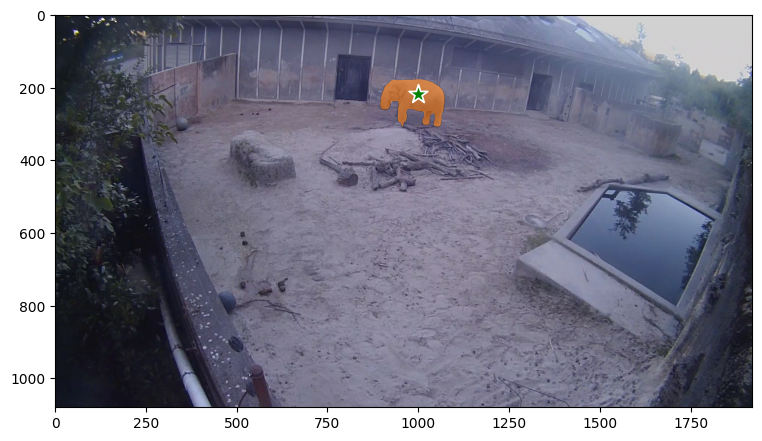

In [9]:
from typing import Any


def add_label_points(
    predictor: SAM2VideoPredictor,
    inference_state: dict[Any, Any],
    obj_id: int,
    record: dict[str, Any],
):
    ann_frame_idx = 0  # the frame index we interact with
    positive_points = np.array(record["ppoints"], dtype=np.float32).reshape((-1, 2))
    negative_points = np.array(record["npoints"], dtype=np.float32).reshape((-1, 2))

    points = np.concatenate([positive_points, negative_points])
    # for labels, `1` means positive click and `0` means negative click
    labels = np.array(
        [1] * positive_points.shape[0] + [0] * negative_points.shape[0], np.int32
    )
    _, _, mask_logits = predictor.add_new_points_or_box(
        inference_state=inference_state,
        frame_idx=ann_frame_idx,
        obj_id=obj_id,
        points=points,
        labels=labels,
    )
    return points, labels, mask_logits


points, labels, mask_logits = add_label_points(
    predictor, inference_state, 1, data_i["records"][0]
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.imshow(frames[1])
show_points(points, labels, plt.gca())
show_mask((mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=1)

In [10]:
# run propagation throughout the video and collect the results in a dict
masks = []
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(
    inference_state
):
    masks.append((out_mask_logits > 0.0).cpu().numpy())

propagate in video: 100%|██████████| 50/50 [00:03<00:00, 13.93it/s]


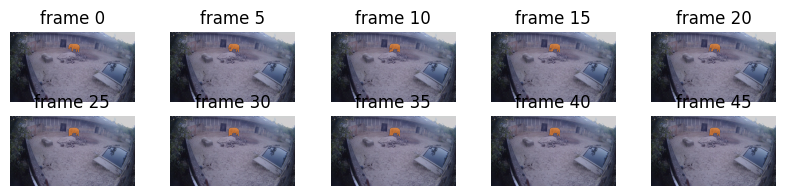

In [11]:
# render the segmentation results every few frames
vis_frame_stride = 5  # frame_count // 1
total_count = frame_count // 5
NCOLS = 5
nrows = int(np.ceil(total_count / NCOLS))
plt.close("all")
fig, axs = plt.subplots(nrows, NCOLS, figsize=(2 * NCOLS, 1 * nrows))
axs = axs.reshape((-1,))
for i, out_frame_idx in enumerate(range(0, frame_count, vis_frame_stride)):
    ax = axs[i]
    ax.set_title(f"frame {out_frame_idx}")
    ax.imshow(frames[out_frame_idx])
    ax.axis("off")
    for obj_id, mask in enumerate(masks[out_frame_idx]):
        show_mask(mask, ax, obj_id=obj_id + 1)

In [12]:
def mask_iou(a, b) -> float:
    overlap_area = (a & b).sum()
    union_area = (a | b).sum()
    iou = overlap_area / union_area
    return iou


ref_mask = None

for frame_idx, mask in enumerate(masks):
    if ref_mask is None:
        ref_mask = mask
    else:
        iou = mask_iou(ref_mask, mask)
        print(iou)

0.9425775480059084
0.9051383399209486
0.8804096274010645
0.8589023213576253
0.8426459676959077
0.8388854208047216
0.8227310344827586
0.8108315518280984
0.8061521252796421
0.7873342354533153
0.7815193965517241
0.774743118777618
0.7757352941176471
0.7749973034192644
0.7825637678794801
0.7904895406512832
0.7995011927998265
0.7984892125427966
0.7972226778196927
0.7966900420757363
0.7771213748657357
0.7647809442790302
0.766201102370632
0.7654663959824768
0.7680690399137001
0.7645558630419448
0.7727717923604309
0.7746030031327644
0.7722312263641274
0.758344169917642
0.7661463939720129
0.7514916948879213
0.7512903225806452
0.7624516960068699
0.7643931256713211
0.7655762401807812
0.7664099940767863
0.7675445683201378
0.7632571674929942
0.7654261057173678
0.7655499811188434
0.7659299191374663
0.7663052273830717
0.7598993655655217
0.7693305937060668
0.7680272845387613
0.7730041331303024
0.7612238290524498
0.7738674451292031


254 uint8


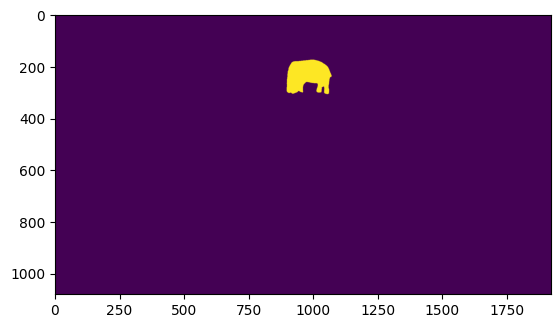

In [13]:
def segmentation_from_masks(
    obj_ids: list[int], masks: torch.Tensor
) -> torch.Tensor | None:
    AREA_THRESHOLD = 1500

    device = masks.device
    obj_count = len(obj_ids)
    intersections = torch.zeros((obj_count,), dtype=torch.int32, device=device)

    segmentation: torch.Tensor | None = None
    for i, (obj_id, mask) in enumerate(zip(obj_ids, masks)):
        mask = mask[0]
        pixel_value = 255 / obj_count * (obj_id + 1)
        if mask.sum().cpu() < AREA_THRESHOLD:
            continue

        mask_u8: torch.Tensor = (mask * pixel_value).to(torch.uint8)
        if segmentation is None:
            segmentation = mask_u8
        else:
            intersections[i] = (segmentation & mask_u8).sum()
            segmentation = segmentation + mask_u8

    # Check intersections
    all_intersections = intersections.sum().cpu()
    assert all_intersections == 0
    return segmentation


segmentation = segmentation_from_masks(out_obj_ids, out_mask_logits > 0.0).cpu().numpy()
print(segmentation.max(), segmentation.dtype)
plt.imshow(segmentation)
# show_mask((out_mask_logits[0]>0.0).cpu().numpy(),plt.gca(),1)

In [14]:
from pathlib import Path


def save_frame(
    path_prefix: Path, index: int, frame: np.ndarray, segmentation: np.ndarray
) -> None:
    path_prefix.parent.mkdir(exist_ok=True, parents=True)
    frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    # cv2.imwrite(f"{str(path_prefix)}_{index:08d}_img.jpg", frame_bgr, [cv2.IMWRITE_JPEG_QUALITY,99])
    cv2.imwrite(f"{str(path_prefix)}_{index:08d}_img.png", frame_bgr)
    cv2.imwrite(f"{str(path_prefix)}_{index:08d}_seg.png", segmentation)


def make_path_prefix(camera_name: str, video_file: Path) -> Path:
    DATA_DIR = Path("/home/dherrera/data/elephants/training_data2")
    prefix = DATA_DIR / camera_name / video_file.with_suffix("").name
    return prefix


save_frame(make_path_prefix(camera_name, video_file), 0, frames[0], segmentation)

In [15]:
import gc

IOU_THRESHOLD = 0.9
MAX_FRAME_COUNT = 500
prefix = make_path_prefix(camera_name, video_file)
for i, data_i in enumerate(tqdm(data, "Labelled frames")):
    frame_count = min(MAX_FRAME_COUNT, distance_to_next_label[i])
    ref_frame_idx = data_i["frame"]
    frames = load_frames(video, ref_frame_idx, frame_count)
    if "inference_state" in locals():
        del inference_state
    gc.collect()
    inference_state = predictor.init_state(video_path=frames)

    for i, record in enumerate(data_i["records"]):
        add_label_points(predictor, inference_state, i, record)

    ref_masks = None

    for sam_frame_idx, obj_ids, mask_logits in predictor.propagate_in_video(
        inference_state
    ):
        if sam_frame_idx % 10 != 0:
            continue

        video_frame_idx = ref_frame_idx + sam_frame_idx

        masks = mask_logits > 0.0
        if ref_masks is None:
            ref_masks = masks
        else:
            iou = mask_iou(ref_masks, masks).cpu().item()
            if iou > IOU_THRESHOLD:
                print(f"Skipping {video_frame_idx} iou={iou}")
                continue
            ref_masks = masks

        segmentation_image = segmentation_from_masks(obj_ids, masks)
        if segmentation_image is None:
            break
        segmentation_image = segmentation_image.cpu().numpy()

        save_frame(prefix, video_frame_idx, frames[sam_frame_idx], segmentation_image)

100%|██████████| 500/500 [00:00<00:00, 638.09it/s]it/s]


Skipping 40 iou=0.9310837984085083


Skipping 50 iou=0.9420721530914307


100%|██████████| 500/500 [00:00<00:00, 680.36it/s]6, 24.66s/it]


Skipping 19353 iou=0.9515785574913025


Skipping 19363 iou=0.9416308999061584


Skipping 19373 iou=0.9668874144554138


Skipping 19383 iou=0.9411455988883972


Skipping 19393 iou=0.9338599443435669


Skipping 19403 iou=0.9086768627166748


Skipping 19413 iou=0.9010480046272278


Skipping 19423 iou=0.9174432754516602


Skipping 19433 iou=0.9382815361022949


Skipping 19443 iou=0.9359601140022278


Skipping 19473 iou=0.9482520818710327


Skipping 19483 iou=0.9158585071563721


Skipping 19503 iou=0.9278069734573364


Skipping 19513 iou=0.9006509184837341


Skipping 19533 iou=0.9390321969985962


Skipping 19543 iou=0.9156132340431213


Skipping 19553 iou=0.9045637249946594


100%|██████████| 500/500 [00:00<00:00, 733.67it/s]1, 34.57s/it]


Skipping 53204 iou=0.9813376665115356


Skipping 53214 iou=0.9831693172454834


Skipping 53224 iou=0.9852941036224365


Skipping 53234 iou=0.9849527478218079


Skipping 53244 iou=0.9793444275856018


Skipping 53254 iou=0.9638292193412781


Skipping 53264 iou=0.9477166533470154


Skipping 53274 iou=0.9622966051101685


Skipping 53284 iou=0.9650247097015381


Skipping 53294 iou=0.9638442397117615


Skipping 53304 iou=0.9716488122940063


Skipping 53314 iou=0.9694717526435852


Skipping 53324 iou=0.96947181224823


Skipping 53334 iou=0.9650602340698242


Skipping 53344 iou=0.9626755714416504


Skipping 53354 iou=0.9560749530792236


Skipping 53364 iou=0.9580170512199402


Skipping 53374 iou=0.9578076004981995


Skipping 53384 iou=0.9594894051551819


Skipping 53394 iou=0.9489755034446716


Skipping 53404 iou=0.9555762410163879


Skipping 53414 iou=0.9595425128936768


Skipping 53424 iou=0.9622765779495239


Skipping 53434 iou=0.9642242193222046


Skipping 53444 iou=0.9735054969787598


Skipping 53454 iou=0.9712186455726624


Skipping 53464 iou=0.9696356058120728


Skipping 53474 iou=0.9735874533653259


Skipping 53484 iou=0.9742765426635742


Skipping 53494 iou=0.9745978713035583


Skipping 53504 iou=0.973336935043335


Skipping 53514 iou=0.9764223694801331


Skipping 53524 iou=0.9744308590888977


Skipping 53534 iou=0.9734621047973633


Skipping 53544 iou=0.9723514914512634


Skipping 53554 iou=0.9736172556877136


Skipping 53564 iou=0.9652150273323059


Skipping 53574 iou=0.9686849117279053


Skipping 53584 iou=0.9605917930603027


Skipping 53594 iou=0.9570937752723694


Skipping 53614 iou=0.930570125579834


Skipping 53624 iou=0.9310728311538696


Skipping 53634 iou=0.9193608164787292


Skipping 53644 iou=0.9224344491958618


Skipping 53654 iou=0.9002867937088013


100%|██████████| 500/500 [00:00<00:00, 726.65it/s]3, 39.08s/it]


Skipping 62497 iou=0.9179266691207886


Skipping 62517 iou=0.9049496054649353


Skipping 62547 iou=0.9124118685722351


Skipping 62617 iou=0.9196931719779968


Skipping 62627 iou=0.9171130061149597


Skipping 62637 iou=0.9233114719390869


Skipping 62647 iou=0.921681821346283


Skipping 62657 iou=0.9200199842453003


Skipping 62667 iou=0.9215221405029297


Skipping 62677 iou=0.9330494403839111


Skipping 62687 iou=0.9346775412559509


Skipping 62697 iou=0.938188374042511


Skipping 62707 iou=0.9486377239227295


Skipping 62717 iou=0.9243957996368408


Skipping 62727 iou=0.9362772107124329


Skipping 62767 iou=0.9391694068908691


Skipping 62777 iou=0.9622892737388611


Skipping 62787 iou=0.9544703364372253


100%|██████████| 68/68 [00:00<00:00, 649.72it/s]:59, 39.93s/it]


Skipping 63102 iou=0.9005926251411438


Skipping 63122 iou=0.9679348468780518


Skipping 63132 iou=0.9454850554466248


Skipping 63142 iou=0.9608591794967651


100%|██████████| 142/142 [00:00<00:00, 710.79it/s]1, 28.21s/it]


Skipping 63160 iou=0.9758832454681396


Skipping 63170 iou=0.9770179986953735


Skipping 63180 iou=0.9660611152648926


Skipping 63190 iou=0.9683064222335815


Skipping 63200 iou=0.9750298261642456


Skipping 63210 iou=0.9652700424194336


Skipping 63220 iou=0.9490190744400024


Skipping 63230 iou=0.9194556474685669


Skipping 63240 iou=0.9374657273292542


Skipping 63250 iou=0.909580647945404


Skipping 63260 iou=0.9052914977073669


Skipping 63270 iou=0.9223486185073853


Skipping 63280 iou=0.9329351186752319


Labelled frames:  64%|██████▎   | 7/11 [03:26<01:30, 22.73s/it]

Skipping 63290 iou=0.9214053750038147


100%|██████████| 500/500 [00:00<00:00, 673.51it/s]


Skipping 63302 iou=0.9409223794937134


Skipping 63312 iou=0.9454876184463501


Skipping 63322 iou=0.9335879683494568


Skipping 63332 iou=0.9361914396286011


Skipping 63342 iou=0.9395338296890259


Skipping 63442 iou=0.9015430808067322


Skipping 63462 iou=0.9213193655014038


Skipping 63472 iou=0.9170227646827698


Skipping 63652 iou=0.928287148475647


100%|██████████| 500/500 [00:00<00:00, 680.73it/s]6, 28.83s/it]


Skipping 69702 iou=0.9150480031967163


Skipping 69712 iou=0.947407603263855


Skipping 69722 iou=0.9421245455741882


Skipping 69732 iou=0.9300423860549927


Skipping 69742 iou=0.913425087928772


Skipping 69762 iou=0.9291252493858337


Skipping 69772 iou=0.9236308932304382


Skipping 69782 iou=0.9486222863197327


Skipping 69792 iou=0.9402510523796082


Skipping 69802 iou=0.9159273505210876


Skipping 69812 iou=0.911021888256073


Skipping 69842 iou=0.9177873730659485


Skipping 69852 iou=0.9510086178779602


Skipping 69862 iou=0.9324533939361572


Skipping 69872 iou=0.9317501187324524


Skipping 69882 iou=0.9376528859138489


Skipping 69892 iou=0.9085174798965454


Skipping 69912 iou=0.9206067323684692


Skipping 69972 iou=0.9275630116462708


Skipping 69982 iou=0.9041022658348083


Skipping 69992 iou=0.9022680521011353


Skipping 70002 iou=0.9197502136230469


100%|██████████| 500/500 [00:00<00:00, 714.41it/s]5, 32.62s/it]


Skipping 83711 iou=0.9017050266265869


Skipping 83721 iou=0.9035196304321289


Skipping 83761 iou=0.9188567996025085


Skipping 83771 iou=0.9059215188026428


Skipping 83791 iou=0.9381285905838013


Skipping 83801 iou=0.9140806794166565


Skipping 83831 iou=0.9094045758247375


Skipping 83841 iou=0.9217524528503418


Skipping 83881 iou=0.9143796563148499


Skipping 83891 iou=0.9096103310585022


Skipping 83901 iou=0.900043249130249


Skipping 83911 iou=0.9113864898681641


Skipping 83981 iou=0.9101606011390686


Skipping 84021 iou=0.9240115880966187


Skipping 84031 iou=0.9110106229782104


Skipping 84121 iou=0.932962954044342


100%|██████████| 500/500 [00:00<00:00, 678.10it/s]34, 34.84s/it]


Skipping 104406 iou=0.9540769457817078


Skipping 104416 iou=0.9226617217063904


Skipping 104426 iou=0.9179562330245972


Skipping 104446 iou=0.9413160681724548


Skipping 104456 iou=0.9101515412330627


Skipping 104466 iou=0.9270581603050232


Skipping 104486 iou=0.9300063848495483


Skipping 104496 iou=0.9062390327453613


Skipping 104556 iou=0.9231929183006287


Skipping 104566 iou=0.9068540334701538


Skipping 104576 iou=0.9030500650405884


Skipping 104596 iou=0.9487060904502869


Skipping 104606 iou=0.9548342227935791


Skipping 104616 iou=0.9424665570259094


Skipping 104626 iou=0.9287567138671875


Skipping 104646 iou=0.9566776752471924


Skipping 104656 iou=0.9406977295875549


Skipping 104666 iou=0.9352213144302368


Skipping 104676 iou=0.9431402087211609


Skipping 104686 iou=0.9415974617004395


Skipping 104696 iou=0.9205209612846375


Skipping 104706 iou=0.9054517149925232


Skipping 104716 iou=0.9478541612625122


Skipping 104726 iou=0.9276444315910339


Skipping 104736 iou=0.9053956866264343


Skipping 104776 iou=0.9265555143356323


Skipping 104816 iou=0.9227047562599182


Skipping 104836 iou=0.914172351360321


Skipping 104856 iou=0.9108105301856995


Skipping 104876 iou=0.9162271618843079


Labelled frames: 100%|██████████| 11/11 [06:07<00:00, 33.45s/it]


In [16]:
import gc
import torch


def _get_less_used_gpu():
    from torch import cuda

    cur_allocated_mem = {}
    cur_cached_mem = {}
    max_allocated_mem = {}
    max_cached_mem = {}
    for i in range(cuda.device_count()):
        cur_allocated_mem[i] = cuda.memory_allocated(i) / 1024 / 1024
        cur_cached_mem[i] = cuda.memory_reserved(i) / 1024 / 1024
        max_allocated_mem[i] = cuda.max_memory_allocated(i) / 1024 / 1024
        max_cached_mem[i] = cuda.max_memory_reserved(i) / 1024 / 1024
    print(cur_allocated_mem)
    print(cur_cached_mem)
    print(max_allocated_mem)
    print(max_cached_mem)
    min_all = min(cur_allocated_mem, key=cur_allocated_mem.get)
    print(min_all)
    return min_all


if "inference_state" in locals():
    del inference_state
gc.collect()
torch.cuda.empty_cache()
_get_less_used_gpu()

{0: 1462.09130859375}
{0: 1562.0}
{0: 8165.6044921875}
{0: 9076.0}
0


0